In [36]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import holoviews as hv
from holoviews import opts
hv.extension('plotly', logo=None)
# hv.extension('matplotlib', logo=None)

### Bathymetrie Haut Fond de Ouessant

(-0.5, 278.5, 524.5, -0.5)

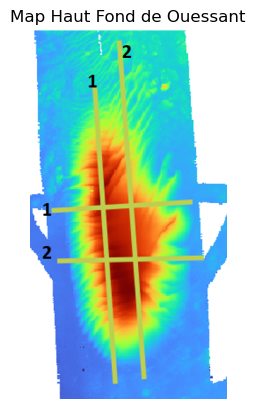

In [37]:
img_path = '/Users/slgentil/Desktop/sandbank/Profil_HFO/Ouessant/Plan_profil.png'
img = plt.imread(img_path)
plt.imshow(img)
plt.title('Map Haut Fond de Ouessant')
plt.axis('off')  # Masquer les axes

In [38]:
# Lecture des fichiers de profil du haut fond d'Ouessant
file_ns_1 = '/Users/slgentil/Desktop/sandbank/Profil_HFO/Ouessant/Profil_HFO_N_S_1.xlsx'
file_ns_2 = '/Users/slgentil/Desktop/sandbank/Profil_HFO/Ouessant/Profil_HFO_N_S_2.xlsx'
file_we_1 = '/Users/slgentil/Desktop/sandbank/Profil_HFO/Ouessant/Profil_HFO_W_E_1.xlsx'
file_we_2 = '/Users/slgentil/Desktop/sandbank/Profil_HFO/Ouessant/Profil_HFO_W_E_2.xlsx'
columns = ['x','z']
dfns1 = pd.read_excel(file_ns_1, header=None, names = columns)
dfns2 = pd.read_excel(file_ns_2, header=None, names = columns)
dfwe1 = pd.read_excel(file_we_1, header=None, names = columns)
dfwe2 = pd.read_excel(file_we_2, header=None, names = columns)

Text(0.5, 1.0, "Profils Nord-Sud du haut fond d'Ouessant")

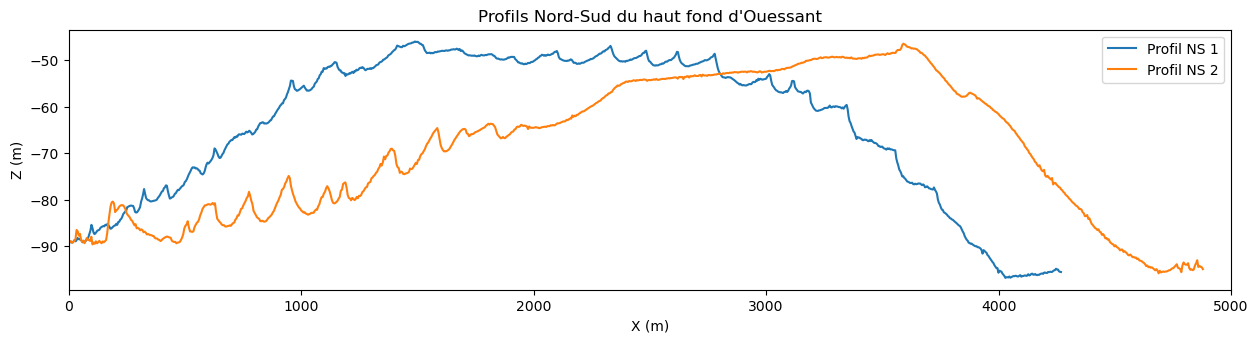

In [39]:
# Plots des profils nord-sud
fig, ax = plt.subplots()
fig.set_figwidth(15) 
ax.set_aspect(20)
ax.plot(dfns1['x'], dfns1['z'], label='Profil NS 1')
ax.plot(dfns2['x'], dfns2['z'], label='Profil NS 2')
ax.legend(loc='upper right')
ax.set_xlabel('X (m)')
ax.set_ylabel('Z (m)')
ax.set_xlim(0,5000)
ax.set_title("Profils Nord-Sud du haut fond d'Ouessant")

Text(0.5, 1.0, "Profils Ouest-Est du haut fond d'Ouessant")

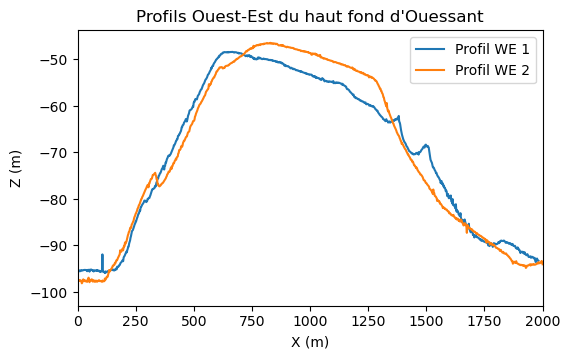

In [40]:
fig, ax = plt.subplots()
fig.set_figwidth(6) 
ax.set_aspect(20)
ax.plot(dfwe1['x'], dfwe1['z'], label='Profil WE 1')
ax.plot(dfwe2['x'], dfwe2['z'], label='Profil WE 2')
ax.legend(loc='upper right')
ax.set_xlabel('X (m)')
ax.set_ylabel('Z (m)')
ax.set_xlim(0,2000)
ax.set_title("Profils Ouest-Est du haut fond d'Ouessant")

### Topographie idéalisée

Creation of a topography in polar coordinates with an elliptical base, 4 defined slopes (W,S,E,N) and a rotation angle

Input parameters:

- $ maxdepth $ : maximum depth of the topography 

- $ hmaxbank $ : max height of the sandbank

- $ r_{ellipse} $ : radius of the ellipse west/east, south/north
  
- $ \delta_{ellipse} $ : slopes of the sandbank west, south, east, north
  
- $ \theta_{ellipse} $ : rotation of the ellipse 

Create the topography:

- Compute the radius for every azimut

$
\begin{align}
r = \sqrt((x-x_{mid_ellipse})**2 + (y-yx_{mid_ellipse})**2)
\end{align}
$

- Compute the slope for every azimut, $ \delta $, with a linear function

- Compute the topography
$
\begin{align}
h = maxdepth - hmaxbank * 0.5 * (1 - \tan(\sinh(\sinh(\frac{r-r_{ellipse}}{2\delta}))))
\end{align}
$

In [41]:
# Paramètres
Lmm = 60
Mmm = 120
N = 20

Length_XI = 6000
Length_ETA = 15000
hocean=100.

a_ellipse = 1000         # demi axe de l'ellipse en x
b_ellipse = 2500        # demi axe de l'ellipse en y
hmaxbank=50.        # hauteur max du banc par rapport au fond
thetae = np.pi/28         # angle de rotation de l'ellipse
delta0 = min(a_ellipse,b_ellipse)/2.
delta1 = max(a_ellipse,b_ellipse)

x = np.linspace(0,Length_XI,Lmm)
y = np.linspace(0,Length_ETA,Mmm)
z = np.linspace(-hocean,-hmaxbank, N)

x,y=np.meshgrid(x,y)

In [42]:
# Création de la topographie en coordonnées polaires avec une base elliptique et des pentes en tangente hyperbolique

xmide = Length_XI/2.        # centre ellipse en x
ymide = Length_ETA/2.       # centre ellipse en y

# Calcul du rayon pour tous les points de la grille
r = np.sqrt((x-xmide)**2 + (y-ymide)**2)

# Calcul de l'azimut pour tous les points de la grille
theta = np.arctan2((y-ymide),(x-xmide)) - thetae
print(np.min(theta), np.max(theta))

# Calcul du rayon de l'ellipse pour tous les azimuts
r_ellipse = 1. / np.sqrt((np.cos(theta)**2/a_ellipse**2)+(np.sin(theta)**2/b_ellipse**2))
print("min/max r_ellipse:",np.min(r_ellipse), np.max(r_ellipse))

# calcul de la longueur de pente pour tous les azimuts
# Définition d'une fonction lineaire à partir de deux points
def equation_droite(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    
    if x2 != x1:
        pente = (y2 - y1) / (x2 - x1)
        ordonnee = y1 - pente * x1
        def F(x):
            print("x1,x2,pente,ordonnee,min/max(x)=",x1,x2,pente,ordonnee,np.min(pente*x + ordonnee),np.max(pente*x + ordonnee))
            return pente*x + ordonnee
        return F
        # return f"y = {pente}x + {ordonne/e_origine}"
    else:
        print("Les deux points doivent être distincts")
        return None
    
# fonction de lissage aus points de raccord

def spline_lissage_2d(topographie):
    hauteur, largeur = len(topographie), len(topographie[0])
    print("hauteur,largeur,shape=",hauteur,largeur,topographie.shape)
    result = [[0]*largeur for _ in range(hauteur)]
    
    # Appliquer un lissage simple par moyenne mobile
    for i in range(1, hauteur-1):
        for j in range(1, largeur-1):
            result[i][j] = (
                topographie[i-1][j-1] + topographie[i-1][j] + topographie[i-1][j+1] +
                topographie[i][j-1] + topographie[i][j] + topographie[i][j+1] +
                topographie[i+1][j-1] + topographie[i+1][j] + topographie[i+1][j+1]
            ) / 9
    
    # Copier les bords sans lissage
    for i in range(hauteur):
        result[i][0] = topographie[i][0]
        result[i][largeur-1] = topographie[i][largeur-1]
    for j in range(largeur):
        result[0][j] = topographie[0][j]
        result[hauteur-1][j] = topographie[hauteur-1][j]
    
    return np.asarray(result)

# definition des 4 points cardinaux et des pentes associées(rayon_ellipse/longueur pente)
pointWM = (-np.pi-thetae, 0.5)
pointS = (-np.pi/2-thetae, 0.6)
pointE = (0.-thetae, 0.78)
pointN = (np.pi/2-thetae, 0.4)
pointWP = (np.pi-thetae, pointWM[1])
dtheta = 30
delta = np.zeros_like(theta)

# quart sud-ouest
# masque = (theta+thetae>=-np.pi) & (theta+thetae<=-np.pi/2)
masque = (theta>=pointWM[0]) & (theta<=pointS[0])
FSW = equation_droite(pointWM, pointS)
delta[masque] = FSW(theta[masque]) #* lissage(theta[masque], pointWM[0], pointS[0], dtheta, -dtheta)
# print("!!! min/max delta=", np.min(delta), np.max(delta), delta.shape)
# quart sud-est
# masque = (theta+thetae>=-np.pi/2) & (theta+thetae<=0.)
masque = (theta>=pointS[0]) & (theta<=pointE[0])
FSE = equation_droite(pointS, pointE)
delta[masque]       = FSE(theta[masque]) #* lissage(theta[masque], pointS[0], pointE[0], dtheta, -dtheta)
# print("!!! min/max delta=", np.min(delta), np.max(delta), delta.shape)
# quart nord-est
# masque = (theta+thetae>=0.)       & (theta+thetae<=np.pi/2)
masque = (theta>=pointE[0])       & (theta<=pointN[0])
FNE = equation_droite(pointE, pointN)
delta[masque]  = FNE(theta[masque]) #* lissage(theta[masque], pointE[0], pointN[0], dtheta, -dtheta)
# print("!!! min/max delta=", np.min(delta), np.max(delta), delta.shape)
# quart nord-ouest
# masque = (theta+thetae>=np.pi/2)  & (theta+thetae<=np.pi)
masque = (theta>=pointN[0])  & (theta<=pointWP[0])
FNW = equation_droite(pointN, pointWP)
delta[masque]    = FNW(theta[masque]) #* lissage(theta[masque], pointN[0], np.abs(pointWP[0]), dtheta, -dtheta)
# print("!!! min/max delta=", np.min(delta), np.max(delta), delta.shape)

# # delta = delta0 + r_ellipse*np.abs(np.sin(theta/4))
# # delta = 2*r_ellipse /3.
delta = 0.5*delta * r_ellipse
print("before min/max delta=", np.min(delta), np.max(delta), delta.shape)
delta = spline_lissage_2d(delta)
print("after min/max delta=", np.min(delta), np.max(delta), delta.shape)



# Application de la tangente hyperbolique pour les pentes
# z_ellipse = hmaxbank * np.exp(-(r)**2/delta**2)
# z_ellipse = hmaxbank * 0.5 * (1 - np.tanh(((r-r_ellipse/2)/delta)))
# z_ellipse = hmaxbank * 0.5 * (1 - np.tanh(np.sinh(((r-r_ellipse/2)/delta))))
z_ellipse = hmaxbank * 0.5 * (1 - np.tanh(np.sinh(np.sinh(((r-r_ellipse/2)/delta)))))
# z_ellipse = hmaxbank * 0.5 * (1 - np.tanh(np.sinh(np.sinh(np.sinh(((r-r_ellipse/2)/delta))))))
print("before z_ellipse=",np.min(z_ellipse), np.max(z_ellipse))
z_ellipse = spline_lissage_2d(z_ellipse)
print("after z_ellipse=",np.min(z_ellipse), np.max(z_ellipse))



# Création de la topographie
topographie_ellipse = - hocean + z_ellipse
# topographie_ellipse[topographie_ellipse > 0] = 0  # Assure que la topographie ne dépasse pas la surface de l'eau



-3.232787077745823 3.0083876024894094
min/max r_ellipse: 1000.0000000295631 2499.9999324941828
x1,x2,pente,ordonnee,min/max(x)= -3.253792391218 -1.6829960644231035 0.06366197723675812 0.7071428571428571 0.5013372397881166 0.5995683999872443
x1,x2,pente,ordonnee,min/max(x)= -1.6829960644231035 -0.1121997376282069 0.11459155902616468 0.7928571428571429 0.6007768800229601 0.77759296838139
x1,x2,pente,ordonnee,min/max(x)= -0.1121997376282069 1.4585965891666897 -0.24191551349968093 0.7528571428571429 0.40164008004847135 0.7749184888051566
x1,x2,pente,ordonnee,min/max(x)= 1.4585965891666897 3.029392915961586 0.06366197723675812 0.30714285714285716 0.40043160001275563 0.49866276021188327
before min/max delta= 251.1633844909442 768.6189934266525 (120, 60)
hauteur,largeur,shape= 120 60 (120, 60)
after min/max delta= 251.19929305973193 768.5368887614572 (120, 60)
before z_ellipse= 0.0 50.0
hauteur,largeur,shape= 120 60 (120, 60)
after z_ellipse= 0.0 49.986783899175784


/var/folders/mv/gcjk3g210052g3q570q9k_60000gpr/T/ipykernel_65038/4237234837.py:125: RuntimeWarning:

overflow encountered in sinh



Text(0.5, 1.0, 'Coupe Nord-Sud')

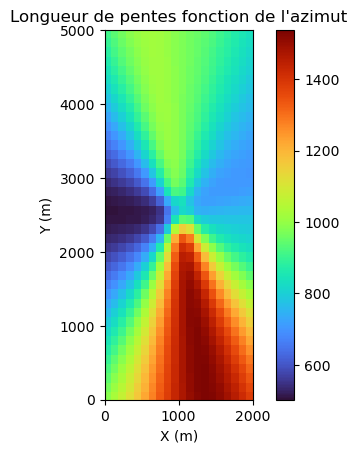

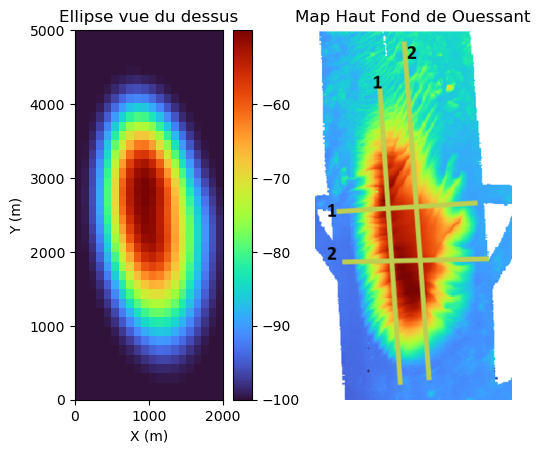

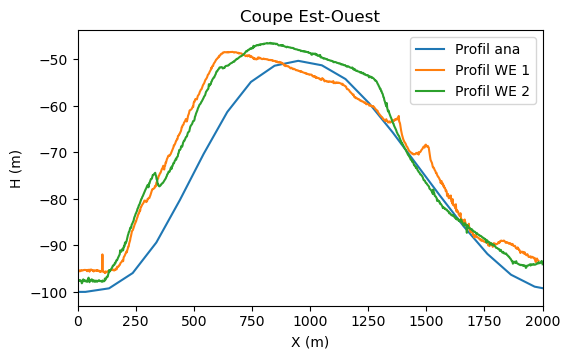

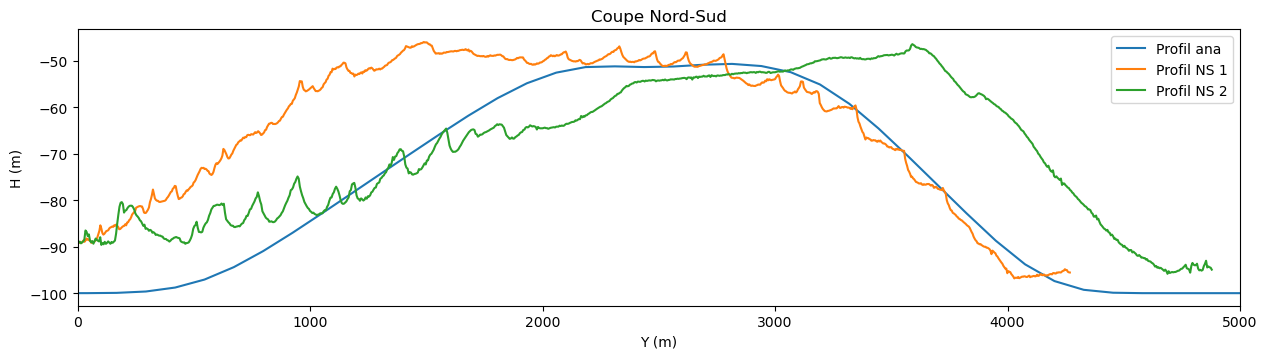

In [44]:
xplot = x - Length_XI/3
yplot = y - Length_ETA/3

# Affichage delta: pente selon tous les azimuts
fig, ax1 = plt.subplots()
fig.set_figwidth(6) 
ax1.set_aspect('equal')
mesh = ax1.pcolormesh(xplot, yplot, 2*delta, cmap="turbo")
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_xlim(0,a_ellipse*2)
ax1.set_ylim(0,b_ellipse*2)
fig.colorbar(mesh, ax=ax1)
ax1.set_title("Longueur de pentes fonction de l'azimut")

# Affichage de la topographie vue du dessus
fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_figwidth(6) 
ax1.set_aspect('equal')
mesh = ax1.pcolormesh(xplot, yplot, topographie_ellipse, cmap="turbo")
ax1.set_xlabel('X (m)')
ax1.set_ylabel('Y (m)')
ax1.set_xlim(0,a_ellipse*2)
ax1.set_ylim(0,b_ellipse*2)
fig.colorbar(mesh, ax=ax1)
ax1.set_title("Ellipse vue du dessus")

# affichage du haut fond de Ouessant
ax2.imshow(img)
ax2.set_title('Map Haut Fond de Ouessant')
ax2.axis('off')  # Masquer les axes

# profil W/E du banc
fig, ax = plt.subplots()
fig.set_figwidth(6) 
ax.set_aspect(20)
ax.plot(xplot[int(Mmm/2),:], topographie_ellipse[int(Mmm/2),:], label='Profil ana')
ax.plot(dfwe1['x'], dfwe1['z'], label='Profil WE 1')
ax.plot(dfwe2['x'], dfwe2['z'], label='Profil WE 2')
ax.legend(loc='upper right')
ax.set_xlabel('X (m)')
ax.set_ylabel('H (m)')
ax.set_xlim(0,a_ellipse*2)
ax.set_title("Coupe Est-Ouest")

# profil N/S du banc
fig, ax = plt.subplots()
fig.set_figwidth(15) 
ax.set_aspect(20)
ax.plot(yplot[:,int(Lmm/2)], topographie_ellipse[:,int(Lmm/2)], label='Profil ana')
ax.plot(dfns1['x'], dfns1['z'], label='Profil NS 1')
ax.plot(dfns2['x'], dfns2['z'], label='Profil NS 2')
ax.legend(loc='upper right')
ax.set_xlabel('Y (m)')
ax.set_ylabel('H (m)')
ax.set_xlim(0,b_ellipse*2)
ax.set_title("Coupe Nord-Sud")


In [45]:
surface = hv.Surface((x[0,:], y[:,0], topographie_ellipse))
surface.opts(colorbar=True, width=800, height=800, aspect={'x':3, 'y':6, 'z':1}, cmap='turbo')

:Surface   [x,y]   (z)

In [86]:
## barotropic prediction from dispersion and polarization relation
g = 9.81
h = 100
zeta0 = 3.
omega = 2*2*np.pi/86400
c = np.sqrt(9.81*h)
f = 2*np.cos(np.deg2rad(48.35))*2*np.pi/86400
k = np.sqrt(omega**2-f**2)/c

print(f" h = {h:.1f} m ")
print(f" c = {c:.1f} m/s")
print(f" omega={omega:.1e} corresponding to {omega*86400/2/np.pi:.1f} cpd")
print(f" k = {k*1000/2/np.pi:.1e} cpkm, corresponding lambda = {2*np.pi/k/1000:.0f} km ")
print(f" f = {f:.2e} ")



 h = 100.0 m 
 c = 31.3 m/s
 omega=1.5e-04 corresponding to 2.0 cpd
 k = 5.5e-04 cpkm, corresponding lambda = 1811 km 
 f = 9.67e-05 


In [90]:
t=150
t = np.arange(0,15.*86400.+150,150)
t2d,y2d = np.meshgrid(t,y)
zeta = zeta0 * np.cos(k*y2d - omega*t2d)
vbar = omega*g*zeta0 * np.cos(k*y2d - omega*t2d)/(c**2 * k)
print("zeta=",np.min(zeta), np.max(zeta))
print("vbar=",np.min(vbar), np.max(vbar))

zeta= -3.0 3.0
vbar= -1.257500564099554 1.257500564099554
